<a href="https://colab.research.google.com/github/210108cse-hash/KNN/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install -q numpy pandas scikit-learn matplotlib seaborn plotly

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score
)
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [5]:
# GitHub raw content URL
GITHUB_RAW_URL = "https://raw.githubusercontent.com/210108cse-hash/KNN/main/winequality-red.csv"
try:
    df = pd.read_csv(GITHUB_RAW_URL, delimiter=',')
    print("✅ Data loaded successfully from GitHub!")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

except Exception as e:
    print(f"Error loading from GitHub: {e}")
    print("Trying alternative method...")

    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

    df = pd.read_csv('winequality-red.csv', delimiter=',')
    print("✅ Data loaded from backup source!")

print("\n📊 Dataset Information:")
print(df.info())
print("\n📈 First 5 rows:")
display(df.head())

✅ Data loaded successfully from GitHub!
Dataset shape: (1599, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

📊 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
print("🧹 Starting Data Preprocessing...")
print("=" * 50)

missing_values = df.isnull().sum()
print("🔍 Missing values:")
print(missing_values[missing_values > 0])

if missing_values.sum() > 0:
    imputer = SimpleImputer(strategy='median')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    print("✅ Missing values imputed!")

print(f"\n🔍 Duplicates: {df.duplicated().sum()} found")
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f"✅ Duplicates removed! New shape: {df.shape}")

df['quality_binary'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

print(f"\n📊 Class distribution:")
print(df['quality_binary'].value_counts())
print(f"Good wine ratio: {df['quality_binary'].mean():.2%}")

X = df.drop(['quality', 'quality_binary'], axis=1)
y = df['quality_binary']

print(f"\n📐 Features shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")

🧹 Starting Data Preprocessing...
🔍 Missing values:
Series([], dtype: int64)

🔍 Duplicates: 240 found
✅ Duplicates removed! New shape: (1359, 12)

📊 Class distribution:
quality_binary
0    1175
1     184
Name: count, dtype: int64
Good wine ratio: 13.54%

📐 Features shape: (1359, 11)
🎯 Target shape: (1359,)


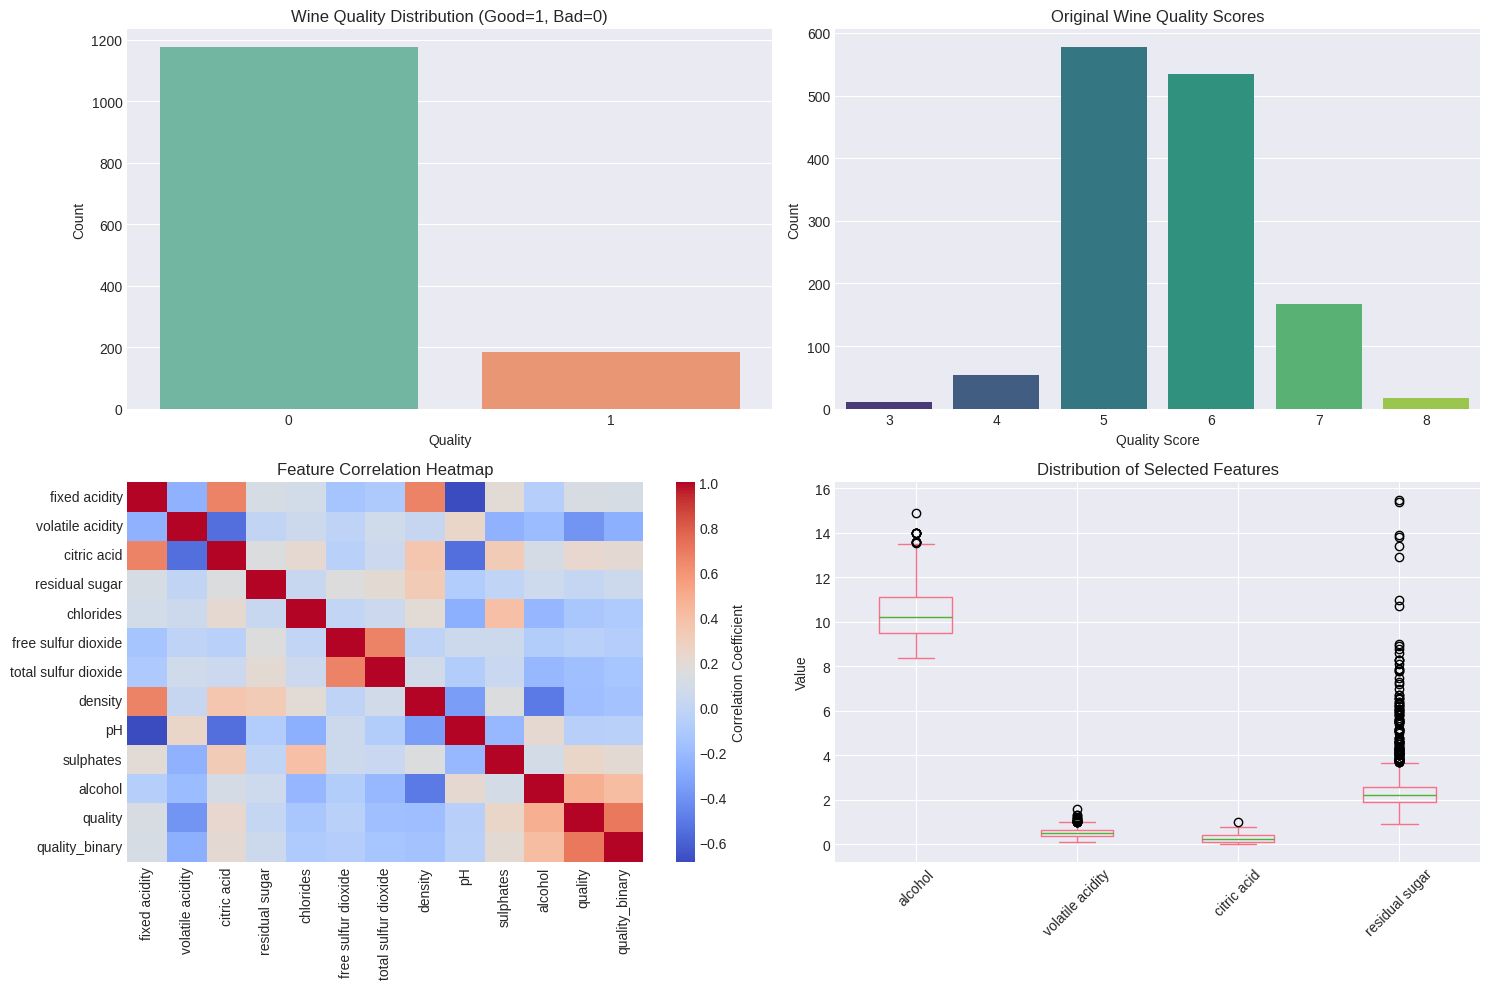

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
sns.countplot(data=df, x='quality_binary', ax=ax1, palette='Set2')
ax1.set_title('Wine Quality Distribution (Good=1, Bad=0)')
ax1.set_xlabel('Quality')
ax1.set_ylabel('Count')

ax2 = axes[0, 1]
sns.countplot(data=df, x='quality', ax=ax2, palette='viridis')
ax2.set_title('Original Wine Quality Scores')
ax2.set_xlabel('Quality Score')
ax2.set_ylabel('Count')

ax3 = axes[1, 0]
correlation = df.corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', ax=ax3,
            cbar_kws={'label': 'Correlation Coefficient'})
ax3.set_title('Feature Correlation Heatmap')

ax4 = axes[1, 1]
sample_features = ['alcohol', 'volatile acidity', 'citric acid', 'residual sugar']
df[sample_features].plot(kind='box', ax=ax4)
ax4.set_title('Distribution of Selected Features')
ax4.set_ylabel('Value')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [8]:
print("🔄 Creating Train/Test/Validation splits...")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"✅ Split completed!")
print(f"Training set: {X_train.shape} ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape} ({X_val.shape[0]/len(X):.1%})")
print(f"Test set: {X_test.shape} ({X_test.shape[0]/len(X):.1%})")

print("\n📊 Class distribution in splits:")
print(f"Train - Good wine: {y_train.mean():.2%}")
print(f"Val - Good wine: {y_val.mean():.2%}")
print(f"Test - Good wine: {y_test.mean():.2%}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features standardized!")

🔄 Creating Train/Test/Validation splits...
✅ Split completed!
Training set: (951, 11) (70.0%)
Validation set: (136, 11) (10.0%)
Test set: (272, 11) (20.0%)

📊 Class distribution in splits:
Train - Good wine: 13.56%
Val - Good wine: 13.24%
Test - Good wine: 13.60%
✅ Features standardized!


In [9]:
print("🤖 Training KNN Classifier...")
print("=" * 50)

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

y_pred_train = knn.predict(X_train_scaled)
y_pred_val = knn.predict(X_val_scaled)

train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)

print(f"📊 Initial Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy:.2%})")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy:.2%})")

🤖 Training KNN Classifier...
📊 Initial Model Performance:
Training Accuracy: 0.9012 (90.12%)
Validation Accuracy: 0.8603 (86.03%)


In [10]:
print("🎯 Performing Hyperparameter Tuning...")
print("=" * 50)

param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Running Grid Search (this may take a few minutes)...")
grid_search.fit(X_train_scaled, y_train)

print("\n✅ Grid Search Completed!")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

best_knn = grid_search.best_estimator_

🎯 Performing Hyperparameter Tuning...
Running Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits

✅ Grid Search Completed!
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 27, 'p': 1, 'weights': 'uniform'}
Best Cross-Validation Score: 0.8780


In [11]:
print("📈 Evaluating Model Performance...")
print("=" * 50)

y_pred_test = best_knn.predict(X_test_scaled)
y_pred_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Bad Wine', 'Good Wine']))

print("\n🎯 Performance Metrics:")
print(f"Accuracy: {accuracy:.4f} ({accuracy:.2%})")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

📈 Evaluating Model Performance...
📊 Classification Report:
              precision    recall  f1-score   support

    Bad Wine       0.90      0.97      0.93       235
   Good Wine       0.61      0.30      0.40        37

    accuracy                           0.88       272
   macro avg       0.75      0.63      0.67       272
weighted avg       0.86      0.88      0.86       272


🎯 Performance Metrics:
Accuracy: 0.8787 (87.87%)
Precision: 0.6111
Recall: 0.2973
F1-Score: 0.4000
AUC-ROC: 0.8260


📊 Generating Confusion Matrix...


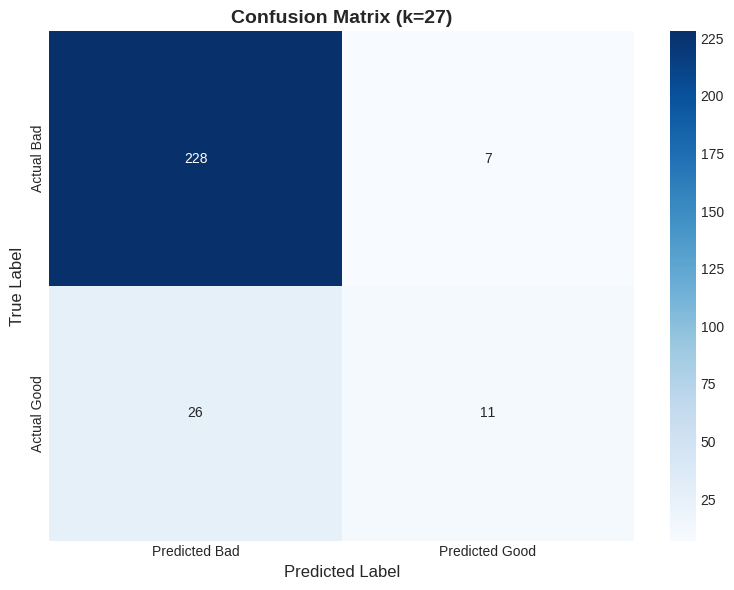

In [12]:
print("📊 Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.title(f'Confusion Matrix (k={best_knn.n_neighbors})', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

📈 Generating Elbow Method Plot...


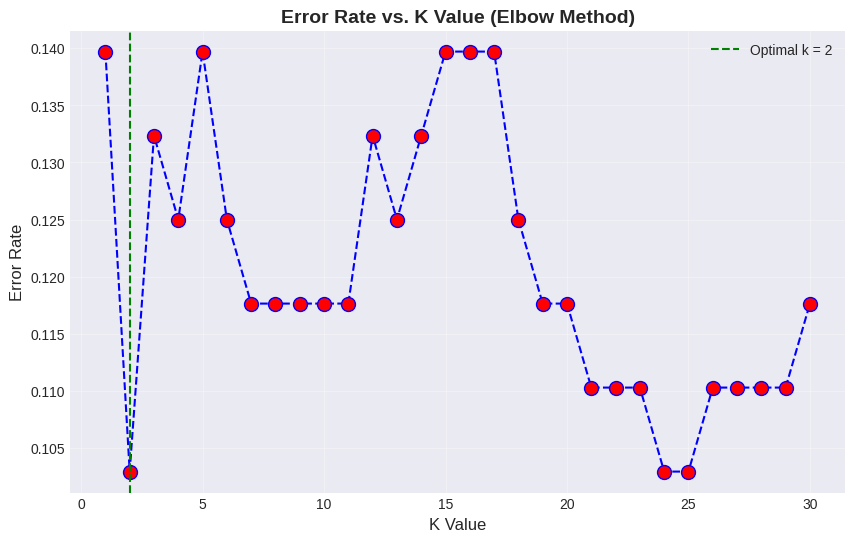

🎯 Optimal k from elbow method: 2


In [13]:
print("📈 Generating Elbow Method Plot...")
error_rate = []

for k in range(1, 31):
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    pred_k = knn_temp.predict(X_val_scaled)
    error_rate.append(np.mean(pred_k != y_val))

optimal_k = error_rate.index(min(error_rate)) + 1

plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), error_rate, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.axvline(x=optimal_k, color='green', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title('Error Rate vs. K Value (Elbow Method)', fontsize=14, fontweight='bold')
plt.xlabel('K Value', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"🎯 Optimal k from elbow method: {optimal_k}")

📊 Generating ROC Curve...


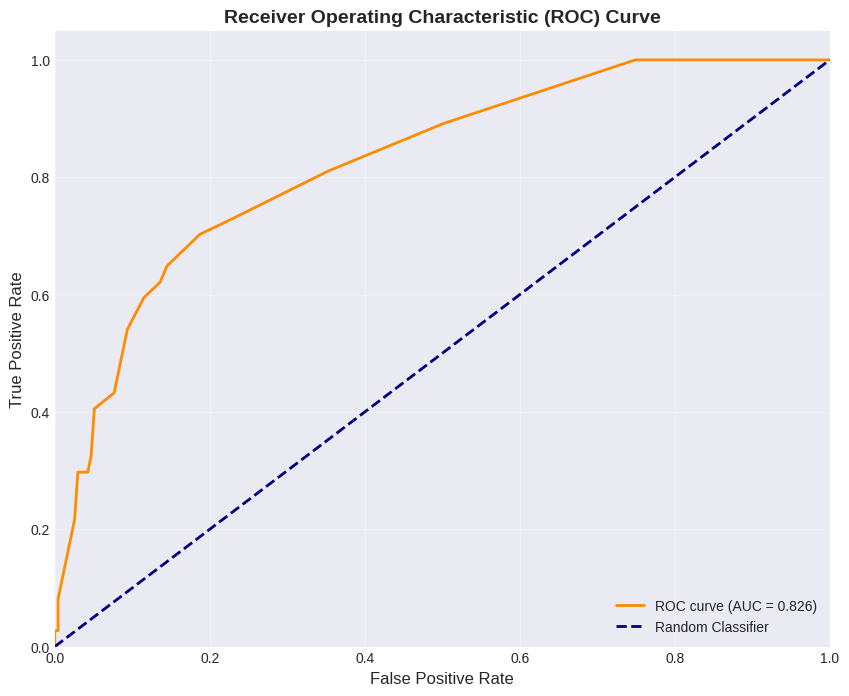

In [14]:
print("📊 Generating ROC Curve...")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

📊 Generating Metrics Summary...


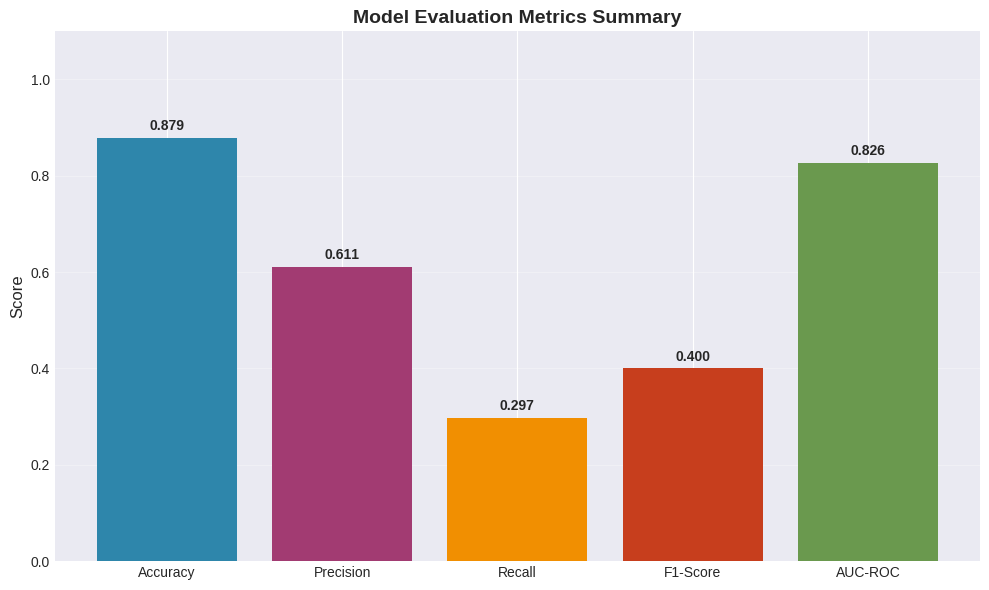

In [15]:
print("📊 Generating Metrics Summary...")
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E'])
plt.ylim(0, 1.1)
plt.title('Model Evaluation Metrics Summary', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()

📊 Generating 2D Decision Boundary...


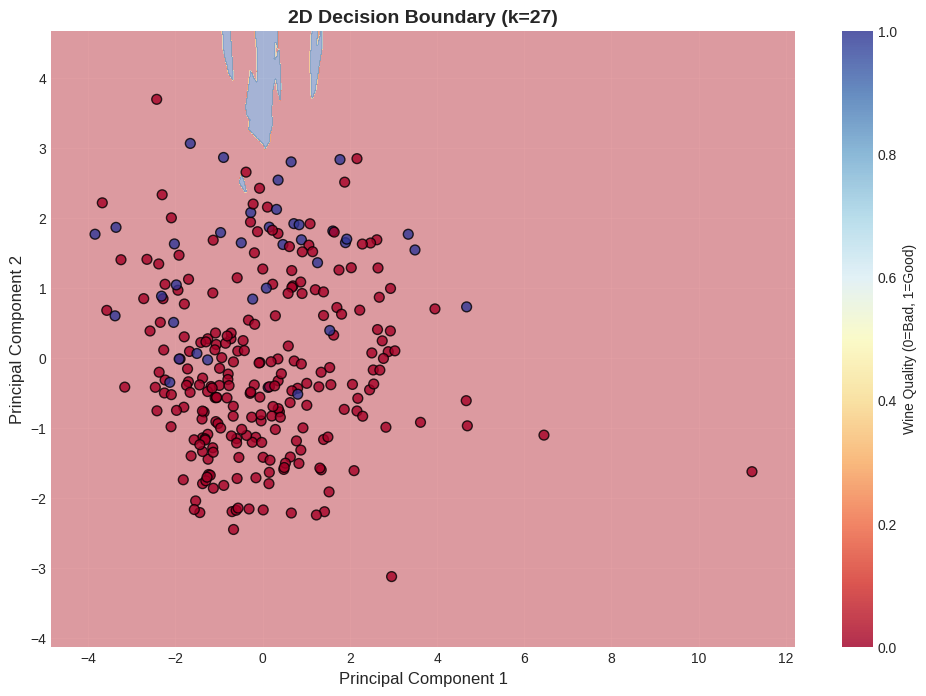

In [16]:
print("📊 Generating 2D Decision Boundary...")
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_scaled)

h = .02
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

knn_2d = KNeighborsClassifier(n_neighbors=best_knn.n_neighbors)
knn_2d.fit(X_test_2d, y_test)

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test,
            cmap='RdYlBu', edgecolor='k', s=50, alpha=0.8)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title(f'2D Decision Boundary (k={best_knn.n_neighbors})', fontsize=14, fontweight='bold')
plt.colorbar(label='Wine Quality (0=Bad, 1=Good)')
plt.grid(True, alpha=0.3)
plt.savefig('decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()